In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os

DIR = "/content/drive/MyDrive/Competitions/Signate/OCEAN180"
INPUT_DIR = os.path.join(DIR,"input")
OUTPUT_DIR = os.path.join(DIR,"output")

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [4]:
train = pd.read_csv(os.path.join(INPUT_DIR,"train_data.csv"))
test = pd.read_csv(os.path.join(INPUT_DIR,"test_data.csv"))
sample_sub = pd.read_csv(os.path.join(INPUT_DIR,"submit_example.csv"), header=None)

print(train.shape)
display(train.head(3))

print(test.shape)
display(test.head(3))

print(sample_sub.shape)
display(sample_sub.head(3))

(14140, 3465)


,Unnamed: 0,lat,lon,area,YMD,year,month,cover,depth_original,cliff_length,...,MIN_NormG_2020,MIN_NormR_2020,MIN_PPR_2020,MIN_PSNDc2_2020,MIN_RDVI_2020,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20
0,0,24.989139,125.243167,20.0,20110926,2011.0,9.0,0.050,NaN,0.0,...,0.507961,0.287288,-0.278071,-0.808075,-2.341663,2.353039,95.142525,3.728732,-2.405135,3725_10
1,1,26.996172,127.912024,40.0,2009.7.6-2009.7.28,2009.0,7.0,0.725,NaN,0.0,...,0.353645,0.245048,-0.100556,-0.771423,-3.282602,4.672225,174.767501,-0.571513,0.448861,4027_13
2,2,26.363556,127.735139,20.0,20091014,2009.0,10.0,0.025,NaN,0.0,...,0.579204,0.281260,-0.191884,-0.853730,-3.160207,3.324236,62.711236,3.284478,-57.136191,3927_22


(4039, 3464)


,Unnamed: 0,lat,lon,area,YMD,year,month,depth_original,cliff_length,aicial_length,...,MIN_NormG_2020,MIN_NormR_2020,MIN_PPR_2020,MIN_PSNDc2_2020,MIN_RDVI_2020,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20
0,0,24.352222,124.202674,20.0,2002.12,2002.0,12.0,0.5,0.000000,725.621704,...,0.409346,0.323023,-0.066356,-0.560810,-3.203797,4.297234,926.905329,1.669992,0.194766,3624_20
1,1,24.420028,124.078583,20.0,20100723,2010.0,7.0,NaN,0.000000,0.000000,...,0.540733,0.275585,-0.291240,-0.824888,-2.222276,2.263106,57.661693,4.274851,-79.273275,3624_20
2,2,26.494197,127.836013,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,13.8,73.183418,80.595177,...,0.601792,0.252251,-0.318454,-0.861477,-2.060505,2.099250,42.672829,5.655713,-2.061417,3927_23


(4039, 2)


,0,1
0,0,0.47
1,1,0.68
2,2,0.25


In [5]:
train.rename(columns={"Unnamed: 0":"id"}, inplace=True)
test.rename(columns={"Unnamed: 0":"id"}, inplace=True)

In [6]:
def missing_func(df):
  total = df.isnull().sum().sort_values(ascending=False)
  percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
  df_missing = pd.concat([total,percent],axis=1,keys=['total','percent'])
  return df_missing 

In [7]:
train_missing = missing_func(train)
test_missing = missing_func(test)

In [8]:
train_cols = train.columns.tolist()
test_cols = test.columns.tolist()

target = set(train_cols) - set(test_cols)
print(target)

display(train[target].head(3))

{'cover'}


,cover
0,0.050
1,0.725
2,0.025


In [9]:
train_area_mean = train.area.mean()
test_area_mean = test.area.mean()
area_mean = (train_area_mean + test_area_mean) / 2
train["area"] = train["area"].fillna(area_mean)
test["area"] = test["area"].fillna(area_mean)

train["cover_area"] = train.cover * train.area
train["cover_area_log"] = np.log1p(train['cover_area'])

max : 3.713572
min : 0.000000


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Skewness: 1.030917
Kurtosis: -0.204865


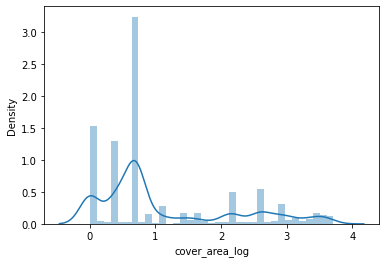

In [10]:
sns.distplot(train["cover_area_log"])

print("max : %f" %train["cover_area_log"].max())
print("min : %f" %train["cover_area_log"].min())
print('Skewness: %f' %train["cover_area_log"].skew())  #歪度
print('Kurtosis: %f' %train["cover_area_log"].kurt())  #尖度

In [11]:
train["adv_flag"] = 0
test["adv_flag"] = 1

df = pd.concat([train,test]).reset_index(drop=True)

In [12]:
train_missing_50 = train_missing[train_missing.percent<0.5].index
test_missing_50 =  test_missing[test_missing.percent<0.5].index

categorical_features = train.dtypes[train.dtypes=="object"].index

features = set(train_missing_50) & set(test_missing_50)
features = set(features) - set(categorical_features) 

In [13]:
display(train[features])

,MIN_GVMI_2012,MED_B11,MED_PPR_2013,MAX_Ferric_Oxides_2002,MIN_IR550_2000,MED_SLAVI_2014,MIN_SWIR1_2000,sst_ymd,MAX_Red_2009,MIN_IR550_2007,...,MAX_TSAVI_2006,MED_SWIR1_2015,MAX_GEMI_2005,MIN_DVIMSS_2003,MED_SIPI2_2001,MIN_Alteration_2017,MED_GEMI_2019,MED_D678_500_2003,MAX_DSWI_2013,MIN_TSAVI_2020
0,0.938259,134.000336,-0.201191,NaN,0.020164,156.587382,0.248642,28.750600,9.131357,0.030261,...,0.052096,0.499423,-62.485331,-0.963978,5.704986,3.839685,-100.702204,-36.313830,2.369332,-0.708291
1,NaN,811.198669,-0.088941,NaN,NaN,336.063956,NaN,27.285750,NaN,0.019958,...,-0.076517,1.161032,-480.370192,NaN,4.510093,3.791243,-291.269263,NaN,2.320836,-0.872407
2,0.913815,1220.452026,-0.161040,0.103064,0.027694,135.549271,0.393852,26.944032,111.936539,0.018840,...,-0.420250,1.189548,-150.037822,1.965468,3.806673,3.887320,-369.998592,-36.263381,2.454326,-0.885153
3,NaN,462.755005,-0.222897,NaN,NaN,177.370844,NaN,21.462371,NaN,NaN,...,NaN,0.660714,NaN,NaN,5.619000,3.765245,-123.439966,NaN,2.776773,-0.750423
4,NaN,406.848724,-0.285668,NaN,NaN,134.134368,NaN,21.429968,NaN,NaN,...,-0.476993,2.380453,NaN,NaN,6.896625,3.406998,-79.562757,NaN,3.070109,-0.708344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14135,NaN,450.751648,-0.198596,0.166384,0.028115,278.057703,0.767322,28.841067,33.325367,0.026780,...,-0.258104,1.494485,-16.146399,17.326177,7.765037,3.825246,-50.618425,-32.816402,2.330839,-0.457364
14136,NaN,695.141846,-0.143774,NaN,NaN,193.739478,NaN,28.070419,NaN,NaN,...,-0.361007,0.646997,NaN,NaN,4.037779,3.456835,-548.625304,NaN,2.784223,-0.979403
14137,0.959829,203.546127,-0.197153,NaN,0.021311,224.007224,3.171100,22.217586,29.190750,NaN,...,-0.567414,0.670761,-245.860439,NaN,NaN,3.635359,-125.239644,NaN,3.003654,-0.778788
14138,NaN,1032.687134,-0.025604,NaN,NaN,1752.232591,NaN,21.467750,NaN,NaN,...,-0.650341,3.497461,NaN,NaN,4.388867,4.179621,-3011.489904,NaN,1.870533,-0.756056


In [14]:
tr_mesh = train.mesh20.value_counts().index
te_mesh = test.mesh20.value_counts().index

test_only_mesh = list(set(te_mesh)-set(tr_mesh))
test_mesh = list(set(te_mesh)-set(test_only_mesh))

In [15]:
def get_mesh_values(df):
  _df = df["mesh20"].str.split('_').apply(pd.Series).astype(float)
  _df.columns = ["mesh20_left","mesh20_right"]
  df["mesh20_left"] = _df["mesh20_left"].astype(int)
  df["mesh20_right"] = _df["mesh20_right"].astype(int)
  return df

In [16]:
train = get_mesh_values(train)
test = get_mesh_values(test)

In [17]:
tr_mesh_l = train.mesh20_left.value_counts().index
te_mesh_l = test.mesh20_left.value_counts().index

tr_mesh_r = train.mesh20_right.value_counts().index
te_mesh_r = test.mesh20_right.value_counts().index

print(set(te_mesh_l)-set(tr_mesh_l))
print(set(te_mesh_r)-set(tr_mesh_r))

set()
set()


## Model

In [18]:
!pip install iterative-stratification

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [19]:
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, GroupKFold, StratifiedGroupKFold, KFold
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score, precision_score, recall_score

In [20]:
class CFG:
  ver=21
  model="lightgbm"
  n_folds=4
  trn_fold=[0, 1, 2, 3]
  seed=42
  target_cols1="adv_flag"
  target_cols2="cover_area_log"
  boosting_type="gbdt"
  fold_target1=["adv_flag", "mesh20"]
  fold_target2="cover_area_log"
  fold_target3="cover_area_log"

In [21]:
# =========================================================================================
# CV split
# =========================================================================================
def get_fold(df,fold_target, isFlag=False):
  if isFlag:
    Fold = MultilabelStratifiedKFold(n_splits=CFG.n_folds, shuffle=True, random_state=CFG.seed)
    for n, (train_index, val_index) in enumerate(Fold.split(df, df[fold_target])):
        df.loc[val_index, 'fold'] = int(n)
  else:
    Fold = GroupKFold(n_splits=CFG.n_folds)
    for n, (train_index, val_index) in enumerate(Fold.split(df, df[fold_target], groups=df["mesh20"])):
      df.loc[val_index, 'fold'] = int(n)
  df['fold'] = df['fold'].astype(int)
  display(df.groupby('fold').size())
  return df

In [22]:
def get_score(labels, preds, isFlag=False):
  if isFlag:
    f1score = f1_score(labels, preds)
    pscore = precision_score(labels, preds)
    rscore =recall_score(labels, preds)
    print(f"F1 Score : {f1score}")
    print(f"Precision Score : {pscore}")
    print(f"Recall Score {rscore}")
  else:
    rmse = np.sqrt(mean_squared_error(labels, preds))
    print(f"RMSE {rmse}")

In [23]:
features = list(features)
features.remove('id')
features.remove('area')

In [24]:
params1 = {
        'objective': "binary",
        'metric': 'binary_logloss',
        'learning_rate': 0.1,
        'boosting': CFG.boosting_type,
        'seed': CFG.seed,
        "reg_alpha":0.5,
        "n_estimators":1000
    }

params2 = {
        'objective': 'regression',
        'metric': 'rmse',
        'learning_rate': 0.1,
        'boosting': CFG.boosting_type,
        'seed': CFG.seed,
        "reg_alpha":0.5,
        "n_estimators":1000
    }

In [25]:
def get_pred(df, test, fold_target, target_cols, model, isFlag=False):
  if isFlag:
    pred_name = "flag"
    train = get_fold(df, fold_target, isFlag=True)
  else:
    pred_name = ""
    train = get_fold(df, fold_target, isFlag=False)
  oof_df = pd.DataFrame()
  df_importance = pd.DataFrame({'feature': features})
  df_importance['importance'] = 0
  test_preds = np.zeros((len(test), CFG.n_folds))

  for fold in range(CFG.n_folds):
    if fold in CFG.trn_fold:
      print("="*15,f" FOLD : {fold} ","="*15)
      train_folds = train[train['fold'] != fold]
      valid_folds = train[train['fold'] == fold]

      train_X = train_folds[features].values
      valid_X = valid_folds[features].values
      test_X = test[features].values
      train_labels = train_folds[target_cols].values
      valid_labels = valid_folds[target_cols].values

      clf = model
      #model = lgb.LGBMRegressor(**params)
      clf.fit(train_X, train_labels,
              eval_set=[(valid_X, valid_labels)],
              #eval_metric="rmse",
              verbose = 200,
              early_stopping_rounds=50)
      
      if isFlag:
        pred = model.predict_proba(valid_X)
        valid_folds[f"{pred_name}_pred_values"] = pred[:,1]
        valid_folds[f"{pred_name}_pred"] = (valid_folds[f"{pred_name}_pred_values"]>.1).astype(int)
      else:
        valid_folds[f"{pred_name}_pred"] = model.predict(valid_X)
        test_preds[:, fold] = model.predict(test_X)
      oof_df = pd.concat([oof_df, valid_folds])

      f_importance = np.array(model.feature_importances_)
      temp_importance = pd.DataFrame({'feature': features, 'importance': f_importance})
      df_importance['importance'] += temp_importance['importance']

      get_score(valid_labels, valid_folds[f"{pred_name}_pred"], isFlag)

  df_importance['importance'] = df_importance['importance'] / np.sum(df_importance['importance'])
  df_importance = df_importance.sort_values('importance', ascending=False)
  display(df_importance.head(35))
  fig = plt.figure(figsize=(16, 32), tight_layout=True)
  sns.barplot(x="importance", y="feature", data=df_importance.head(35))
  plt.title("LightGBM feature importances")
  get_score(oof_df[target_cols], oof_df[f"{pred_name}_pred"], isFlag)
  if isFlag:
    return oof_df
  else:
    return oof_df,  test_preds

fold
0    4544
1    4545
2    4545
3    4545
dtype: int64

===============  FOLD : 0  ===============
Training until validation scores don't improve for 50 rounds.
[200]	valid_0's binary_logloss: 0.00977784
Early stopping, best iteration is:
[173]	valid_0's binary_logloss: 0.00973123


<ipython-input-25-4e8d325e2ecd>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred_values"] = pred[:,1]
<ipython-input-25-4e8d325e2ecd>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred"] = (valid_folds[f"{pred_name}_pred_values"]>.1).astype(int)


F1 Score : 0.9901768172888016
Precision Score : 0.9824561403508771
Recall Score 0.998019801980198
===============  FOLD : 1  ===============
Training until validation scores don't improve for 50 rounds.
[200]	valid_0's binary_logloss: 0.010101
Early stopping, best iteration is:
[175]	valid_0's binary_logloss: 0.010101


<ipython-input-25-4e8d325e2ecd>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred_values"] = pred[:,1]
<ipython-input-25-4e8d325e2ecd>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred"] = (valid_folds[f"{pred_name}_pred_values"]>.1).astype(int)


F1 Score : 0.9819424109321621
Precision Score : 0.9682386910490857
Recall Score 0.996039603960396
===============  FOLD : 2  ===============
Training until validation scores don't improve for 50 rounds.
[200]	valid_0's binary_logloss: 0.0133468
Early stopping, best iteration is:
[178]	valid_0's binary_logloss: 0.0133463


<ipython-input-25-4e8d325e2ecd>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred_values"] = pred[:,1]
<ipython-input-25-4e8d325e2ecd>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred"] = (valid_folds[f"{pred_name}_pred_values"]>.1).astype(int)


F1 Score : 0.9853372434017597
Precision Score : 0.9720347155255545
Recall Score 0.9990089197224975
===============  FOLD : 3  ===============
Training until validation scores don't improve for 50 rounds.
[200]	valid_0's binary_logloss: 0.0107657
Early stopping, best iteration is:
[175]	valid_0's binary_logloss: 0.0107634


<ipython-input-25-4e8d325e2ecd>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred_values"] = pred[:,1]
<ipython-input-25-4e8d325e2ecd>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred"] = (valid_folds[f"{pred_name}_pred_values"]>.1).astype(int)


F1 Score : 0.986809965803615
Precision Score : 0.973963355834137
Recall Score 1.0


,feature,importance
1776,sst_diff,0.031426
7,sst_ymd,0.029423
726,river_area,0.028755
1496,Salinity_annual,0.026180
358,year,0.026085
1914,hist_warm_sst,0.025322
2691,lat,0.023224
1660,river_dist,0.022794
1038,lon,0.019552
2116,month,0.018312


F1 Score : 0.9860601614086573
Precision Score : 0.9741483450108722
Recall Score 0.9982668977469671


/usr/local/lib/python3.8/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


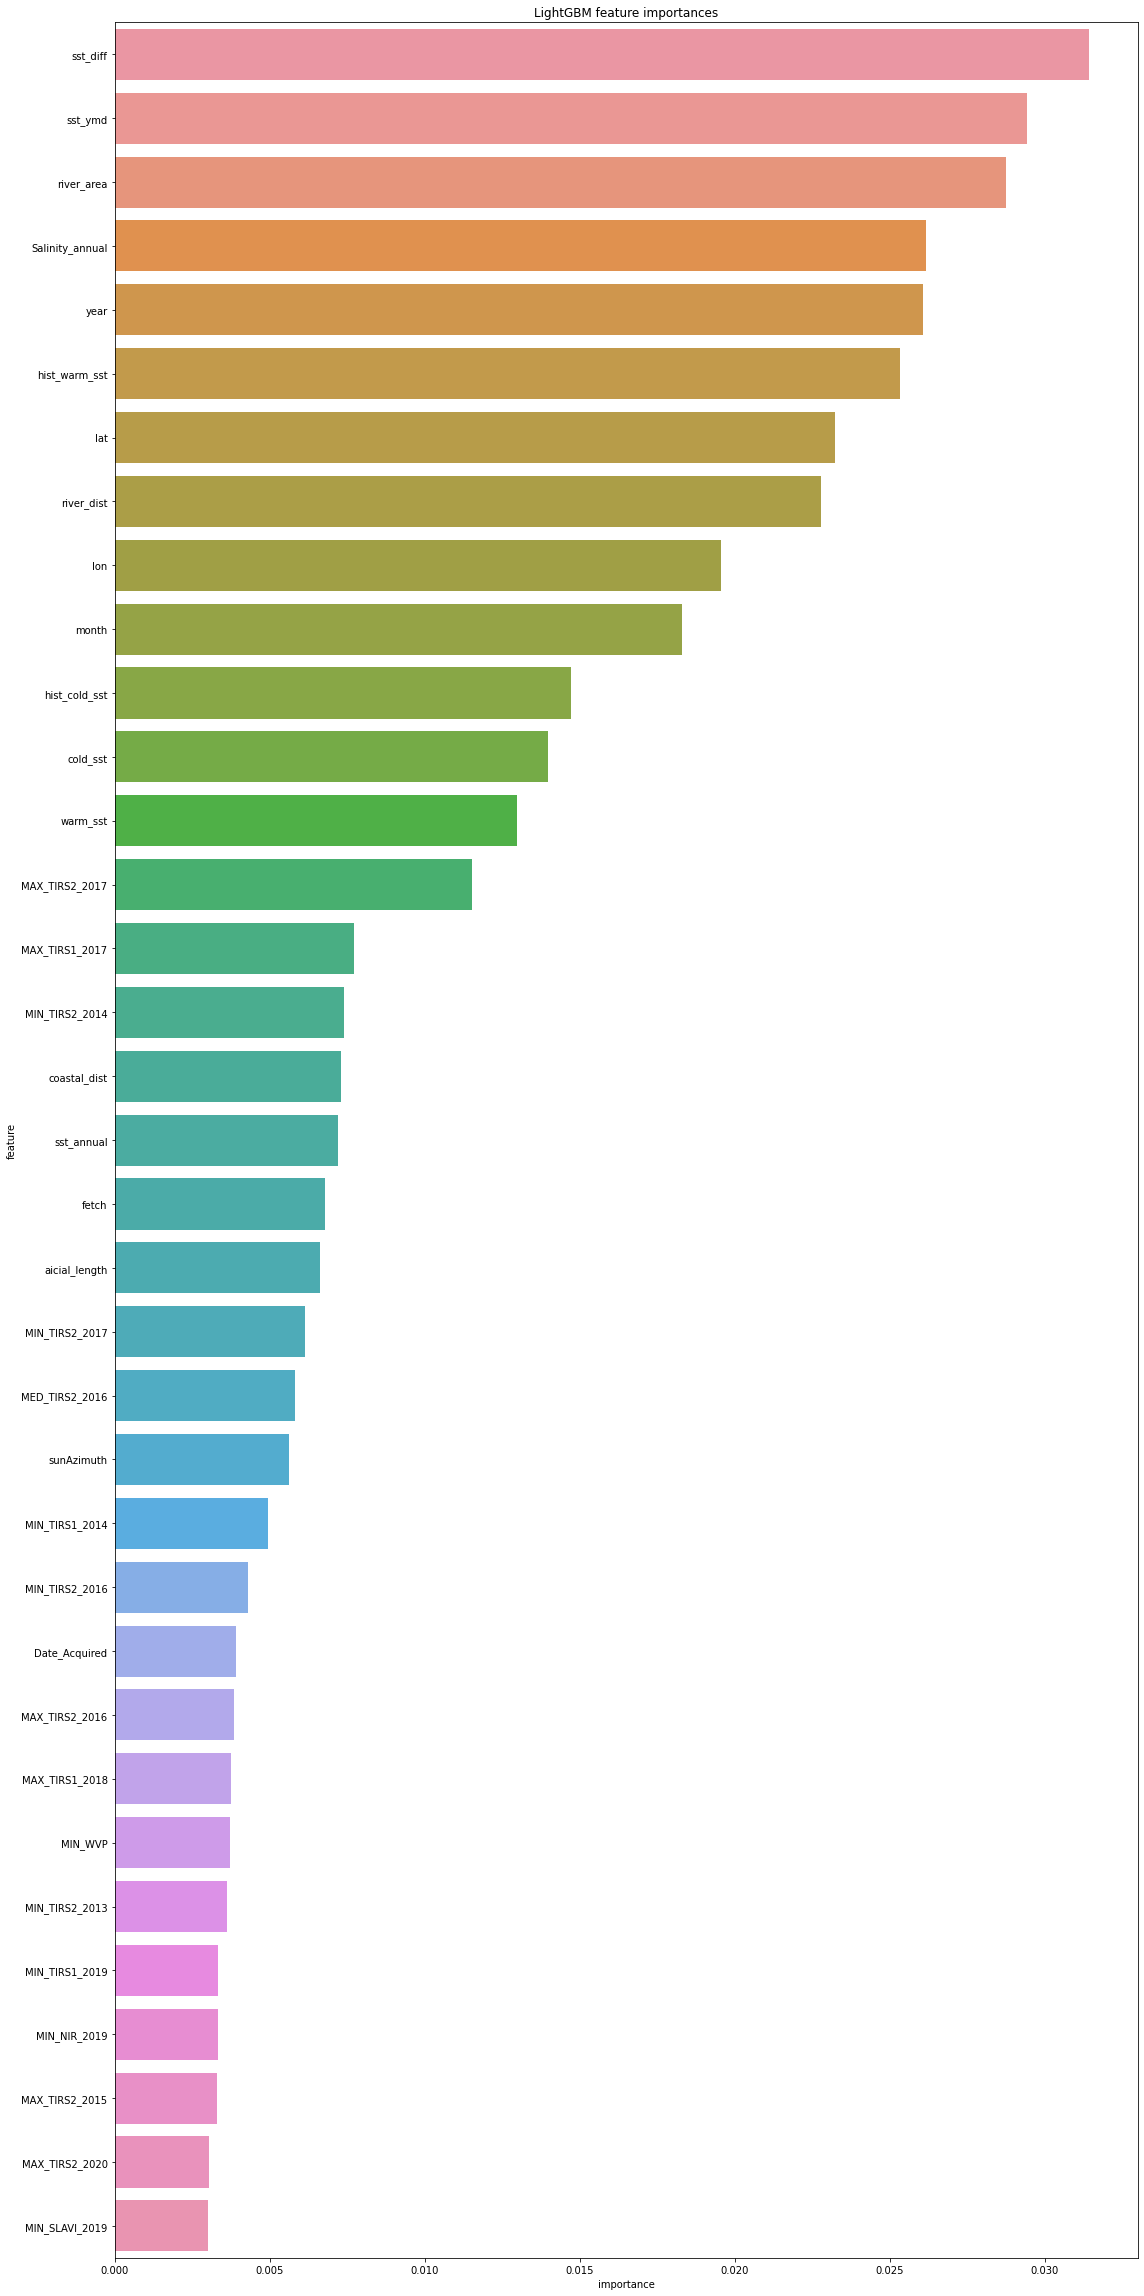

In [26]:
model1 = lgb.LGBMClassifier(**params1)
flag_oof = get_pred(df, test, CFG.fold_target1, CFG.target_cols1, model1, isFlag=True)
oof_train = flag_oof.loc[flag_oof.adv_flag==0]
oof_train.sort_values("flag_pred", ascending=False, inplace=True)
oof_train = oof_train[:len(test)*2].reset_index(drop=True)

fold
0    2019
1    2021
2    2020
3    2018
dtype: int64

===============  FOLD : 0  ===============
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[96]	valid_0's rmse: 0.752673


<ipython-input-25-4e8d325e2ecd>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred"] = model.predict(valid_X)


RMSE 0.7526728261748443
===============  FOLD : 1  ===============
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[4]	valid_0's rmse: 1.55186


<ipython-input-25-4e8d325e2ecd>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred"] = model.predict(valid_X)


RMSE 1.5518554595139982
===============  FOLD : 2  ===============
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[19]	valid_0's rmse: 0.621551


<ipython-input-25-4e8d325e2ecd>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred"] = model.predict(valid_X)


RMSE 0.6215510350900778
===============  FOLD : 3  ===============
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[20]	valid_0's rmse: 0.823956


<ipython-input-25-4e8d325e2ecd>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred"] = model.predict(valid_X)


RMSE 0.8239564338655804


,feature,importance
358,year,0.022542
1914,hist_warm_sst,0.010791
1264,Date_Acquired,0.010552
2501,warm_sst,0.010072
2691,lat,0.009832
1660,river_dist,0.009113
99,depth,0.008393
2116,month,0.006235
2188,MIN_GARI,0.005755
124,MIN_D678_500,0.005276


RMSE 1.0051419702601627


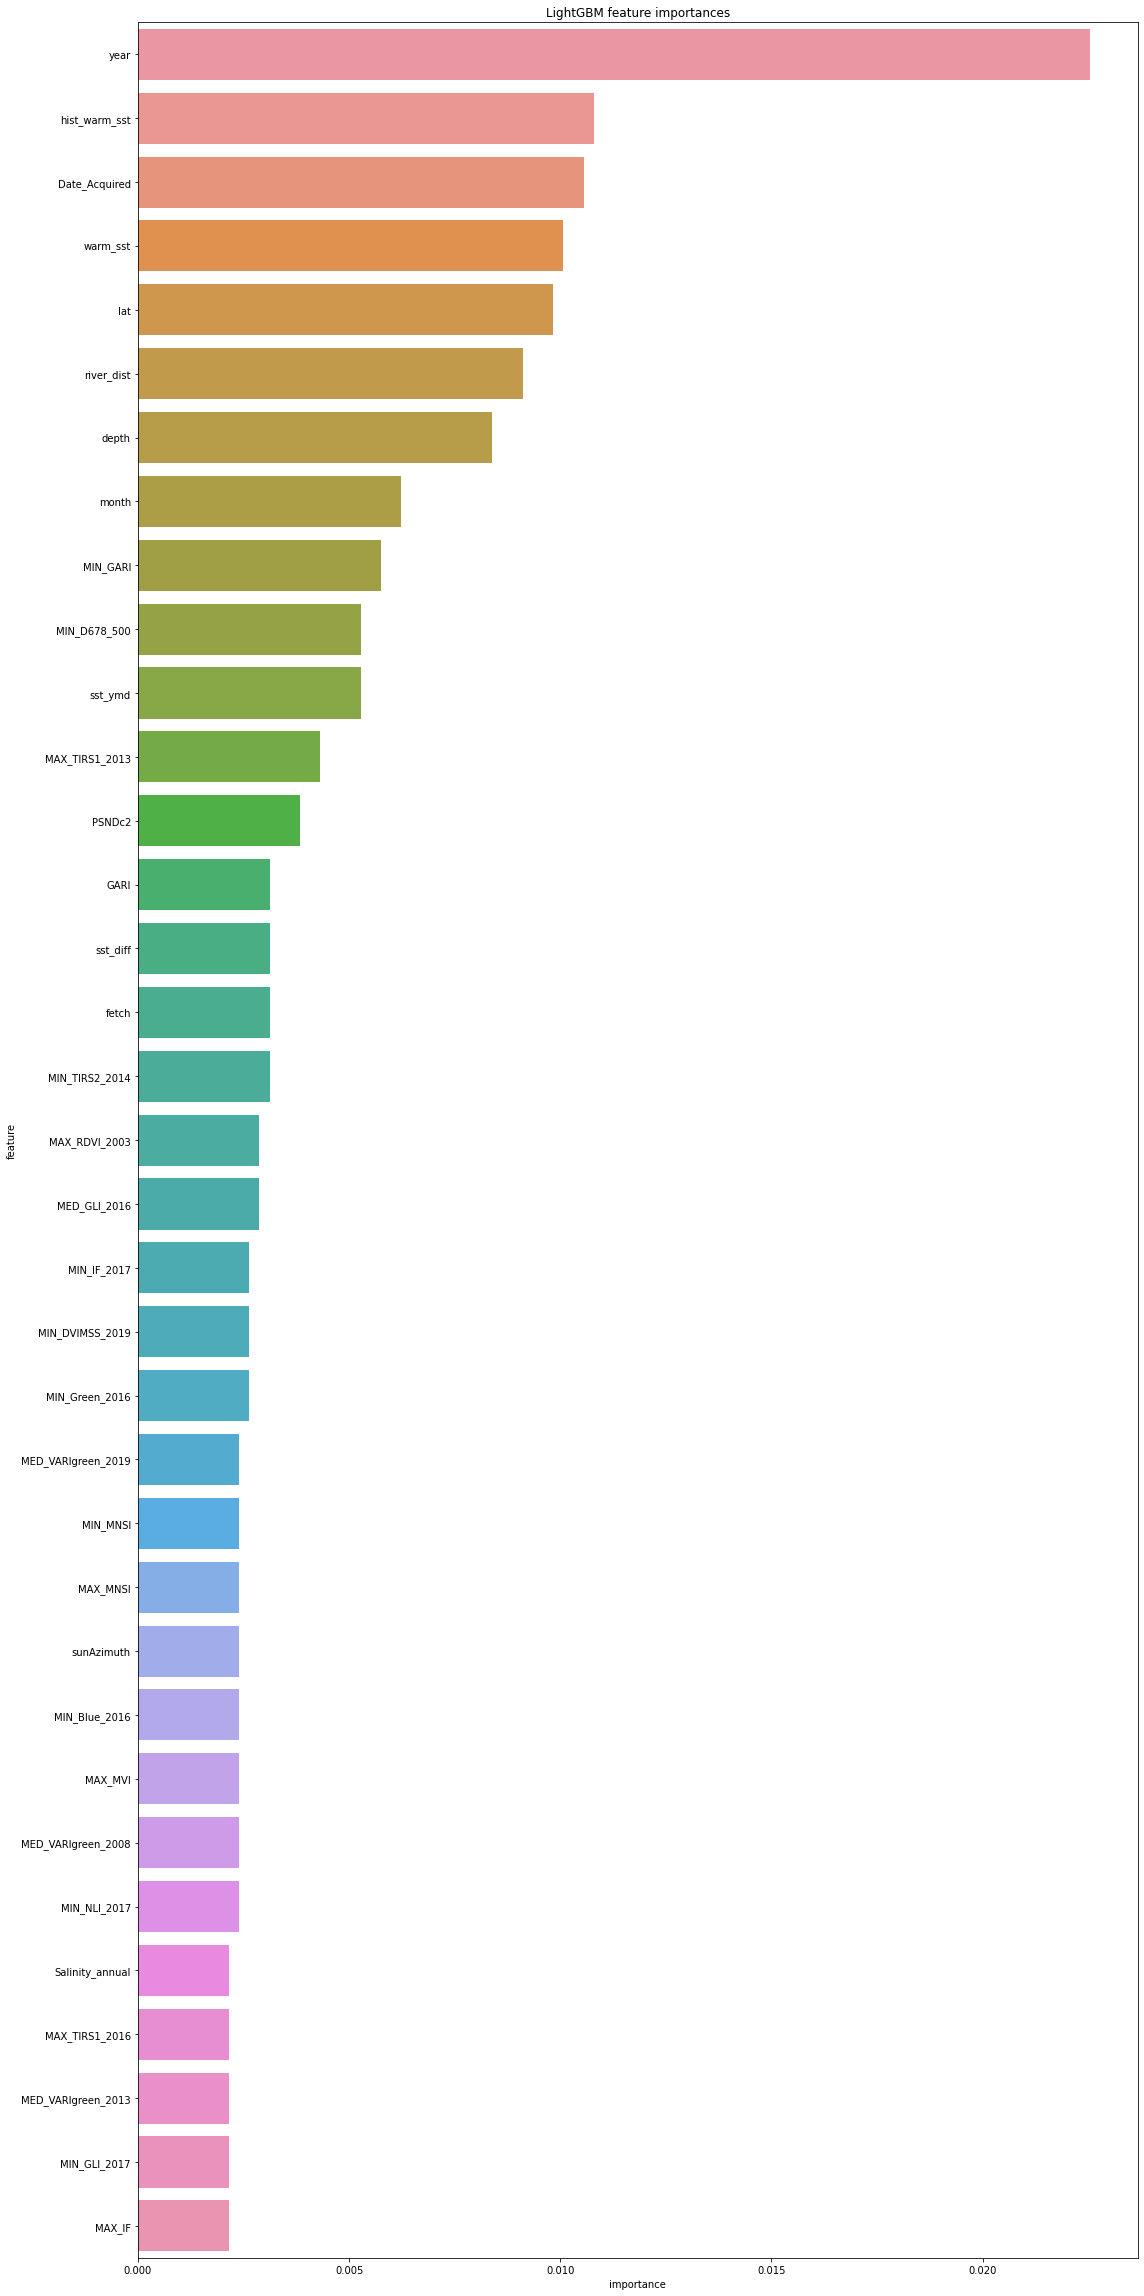

In [27]:
model2 = lgb.LGBMRegressor(**params2)
oof_df, test_pred = get_pred(oof_train, test, CFG.fold_target3, CFG.target_cols2, model2)

In [28]:
cover_max = train.cover.max()
_oof = oof_df.copy()
_oof["pred"] = np.expm1(_oof["_pred"]) / _oof["area"]
_oof["pred"] = _oof["pred"].apply(lambda x: x if x>0 else 0)
_oof["pred"] = _oof["pred"].apply(lambda x: x if x<1 else cover_max)
get_score(_oof["cover"], _oof["pred"])

RMSE 0.28743031362836324


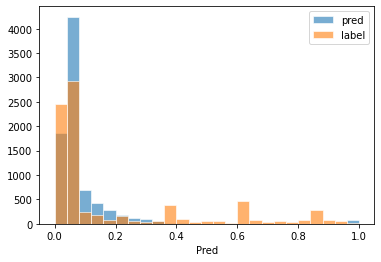

In [29]:
plt.hist(_oof.pred, label='pred', bins=25, edgecolor='white', alpha=.6)
plt.hist(_oof.cover, label="label", bins=25, edgecolor='white', alpha=.6)
plt.xlabel("Pred")
plt.legend()
plt.show()

In [30]:
pred_df = test.copy()
pred_df["pred_area_log"] = np.mean(test_pred, axis=1)

pred_df["pred"] = np.expm1(pred_df["pred_area_log"]) / pred_df['area']
pred_df = pred_df.sort_index()
pred_df

,id,lat,lon,area,YMD,year,month,depth_original,cliff_length,aicial_length,...,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20,adv_flag,mesh20_left,mesh20_right,pred_area_log,pred
0,0,24.352222,124.202674,20.0,2002.12,2002.0,12.0,0.5,0.000000,725.621704,...,4.297234,926.905329,1.669992,0.194766,3624_20,1,3624,20,0.899402,0.072907
1,1,24.420028,124.078583,20.0,20100723,2010.0,7.0,NaN,0.000000,0.000000,...,2.263106,57.661693,4.274851,-79.273275,3624_20,1,3624,20,0.861663,0.068355
2,2,26.494197,127.836013,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,13.8,73.183418,80.595177,...,2.099250,42.672829,5.655713,-2.061417,3927_23,1,3927,23,0.690088,0.009939
3,3,26.183639,127.319361,20.0,20100805,2010.0,8.0,NaN,0.000000,0.000000,...,-10.433323,45.061952,1.546086,-14.527890,3927_11,1,3927,11,0.757317,0.056627
4,4,24.761089,125.269009,20.0,NaN,2019.0,10.0,-0.5,0.000000,34.796036,...,2.563503,80.374689,1.827876,-6.335208,3725_01,1,3725,1,1.298749,0.133235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4034,4034,26.702075,127.873347,20.0,NaN,2019.0,9.0,0.4,0.000000,20.594961,...,3.633575,60.936945,3.053976,-28.354402,4027_03,1,4027,3,0.747207,0.055555
4035,4035,24.337028,124.232694,20.0,20101122,2010.0,11.0,NaN,0.000000,0.000000,...,2.495430,75.231230,3.946128,-2.112646,3624_20,1,3624,20,0.755096,0.056391
4036,4036,26.493121,127.839918,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,0.1,76.439651,133.127228,...,4.403977,117.513676,1.904304,0.601280,3927_23,1,3927,23,0.918768,0.015062
4037,4037,24.068778,123.804194,20.0,20110415,2011.0,4.0,NaN,73.660492,0.000000,...,2.203933,121.654726,2.282056,-2.029225,3623_03,1,3623,3,0.958195,0.080349


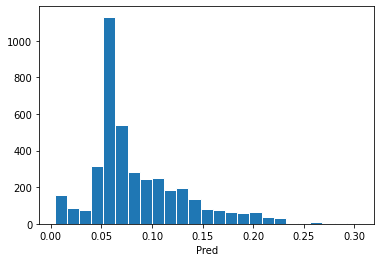

,id,lat,lon,area,YMD,year,month,depth_original,cliff_length,aicial_length,...,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20,adv_flag,mesh20_left,mesh20_right,pred_area_log,pred
0,0,24.352222,124.202674,20.0,2002.12,2002.0,12.0,0.5,0.000000,725.621704,...,4.297234,926.905329,1.669992,0.194766,3624_20,1,3624,20,0.899402,0.072907
1,1,24.420028,124.078583,20.0,20100723,2010.0,7.0,NaN,0.000000,0.000000,...,2.263106,57.661693,4.274851,-79.273275,3624_20,1,3624,20,0.861663,0.068355
2,2,26.494197,127.836013,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,13.8,73.183418,80.595177,...,2.099250,42.672829,5.655713,-2.061417,3927_23,1,3927,23,0.690088,0.009939
3,3,26.183639,127.319361,20.0,20100805,2010.0,8.0,NaN,0.000000,0.000000,...,-10.433323,45.061952,1.546086,-14.527890,3927_11,1,3927,11,0.757317,0.056627
4,4,24.761089,125.269009,20.0,NaN,2019.0,10.0,-0.5,0.000000,34.796036,...,2.563503,80.374689,1.827876,-6.335208,3725_01,1,3725,1,1.298749,0.133235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4034,4034,26.702075,127.873347,20.0,NaN,2019.0,9.0,0.4,0.000000,20.594961,...,3.633575,60.936945,3.053976,-28.354402,4027_03,1,4027,3,0.747207,0.055555
4035,4035,24.337028,124.232694,20.0,20101122,2010.0,11.0,NaN,0.000000,0.000000,...,2.495430,75.231230,3.946128,-2.112646,3624_20,1,3624,20,0.755096,0.056391
4036,4036,26.493121,127.839918,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,0.1,76.439651,133.127228,...,4.403977,117.513676,1.904304,0.601280,3927_23,1,3927,23,0.918768,0.015062
4037,4037,24.068778,123.804194,20.0,20110415,2011.0,4.0,NaN,73.660492,0.000000,...,2.203933,121.654726,2.282056,-2.029225,3623_03,1,3623,3,0.958195,0.080349


In [31]:
pred_df["pred"] = pred_df["pred"].apply(lambda x: x if x>0 else 0)
pred_df["pred"] = pred_df["pred"].apply(lambda x: x if x<1 else 1)
pred_df[["pred"]].to_csv(os.path.join(OUTPUT_DIR, f'submit_{CFG.model}_seed{CFG.seed}_ver{CFG.ver}.csv'), header=False)

plt.hist(pred_df.pred,bins=25,edgecolor='white')
plt.xlabel("Pred")
plt.show()

display(pred_df)